In [2]:
import pandas as pd
import numpy as np

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, f1_score, precision_score, recall_score

import copy
import torch
import torch.nn as nn
from torch.optim import NAdam
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import RandomOverSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Reading the dataset

In [3]:
diabetes=pd.read_csv('diabetes.csv')

In [5]:
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


The dataset has the following features:
- Pregnancies
- Glucose
- BloodPressure
- SkinThickness
- Insulin
- BMI
- DiabetesPedigreeFunction
- Age

In [7]:
diabetes.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [8]:
diabetes_x = diabetes.drop("Outcome", axis=1)
diabetes_y = diabetes["Outcome"]

Exploratory Data Analysis

In [9]:
diabetes_x.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


/tmp/ipykernel_10942/2807747172.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Outcome', data=diabetes, palette='Set2')


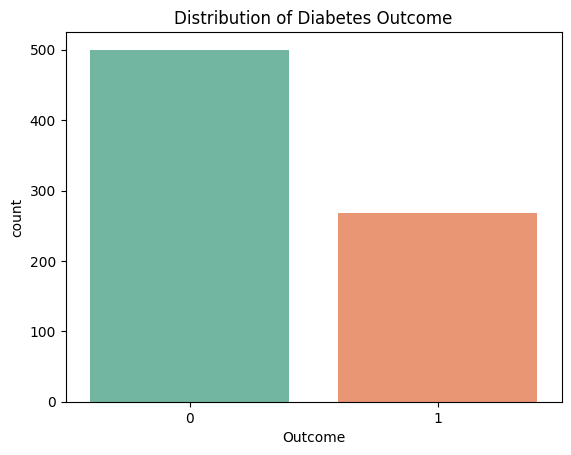

In [10]:
sns.countplot(x='Outcome', data=diabetes, palette='Set2')
plt.title("Distribution of Diabetes Outcome")
plt.show()

In [11]:
diabetes_x_copy=diabetes_x.copy()
diabetes_y_copy=diabetes_y.copy()

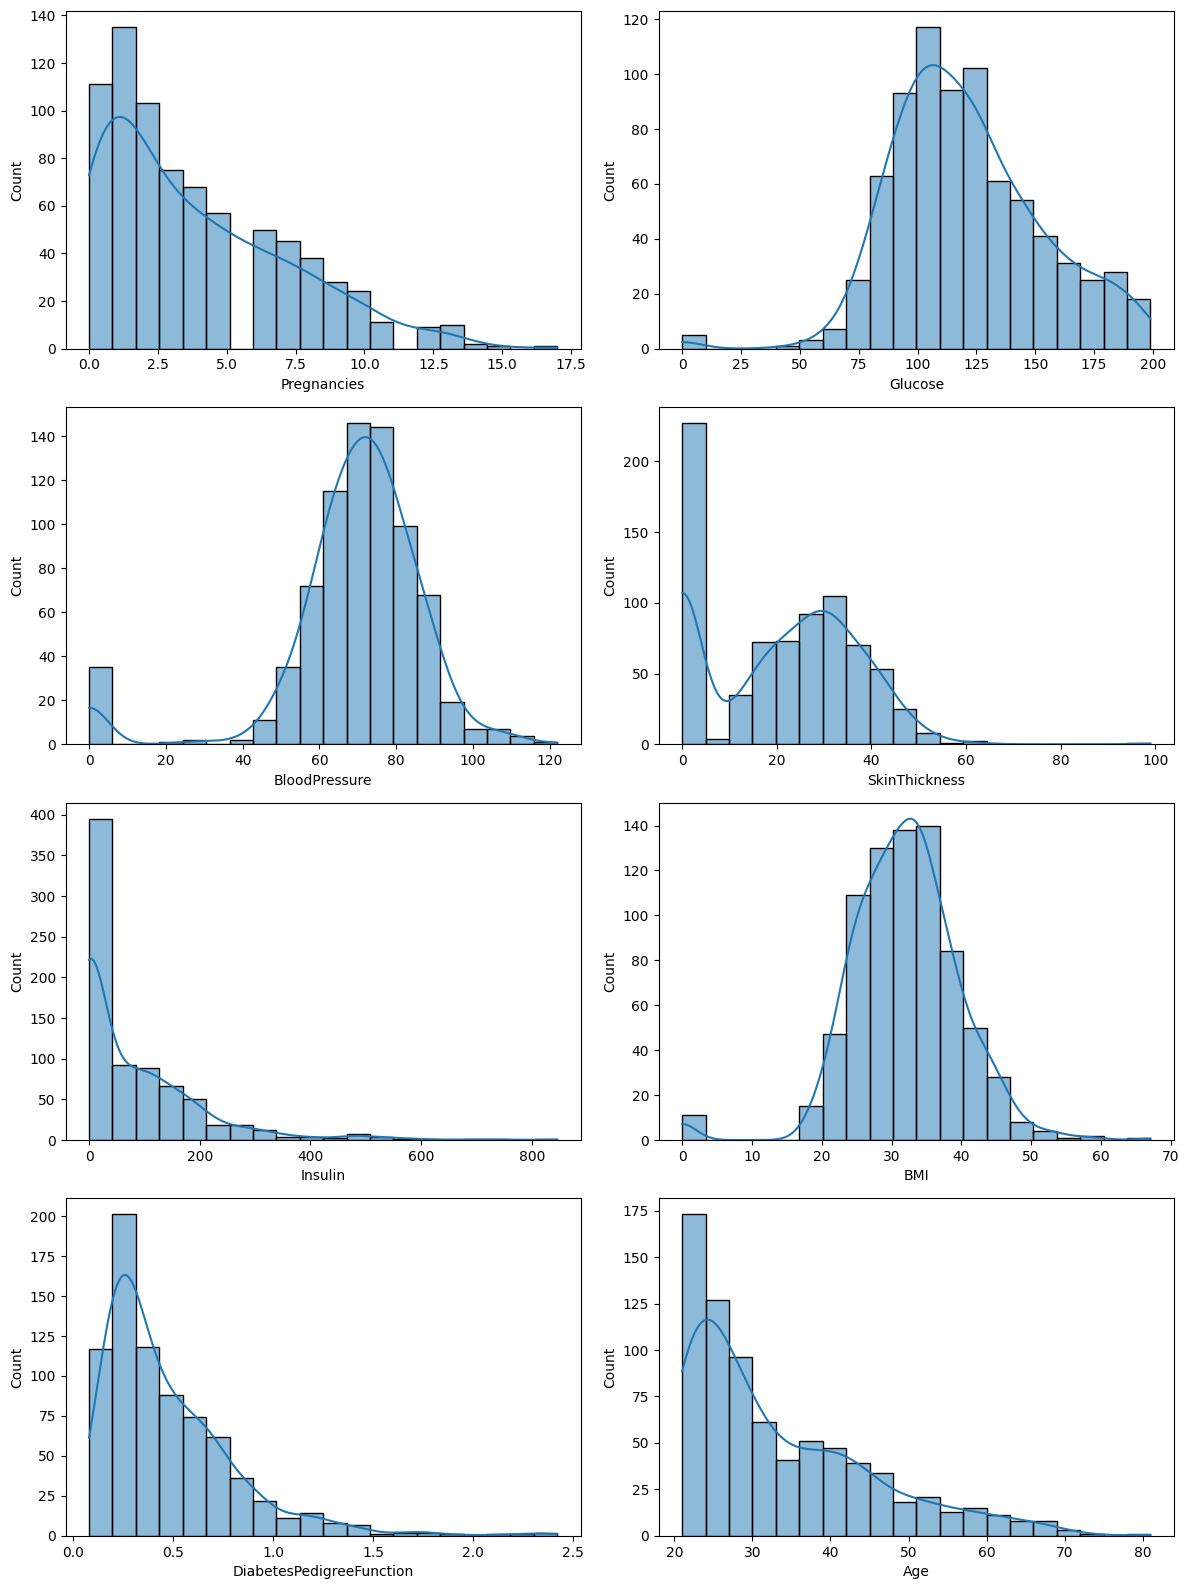

In [31]:
fig, axes = plt.subplots(4, 2, figsize=(12, 16))
for col in diabetes_x.columns:
    sns.histplot(data=diabetes_x, x=col, kde=True, ax=axes.flatten()[diabetes_x.columns.get_loc(col)], bins=20)
plt.tight_layout()
plt.show()

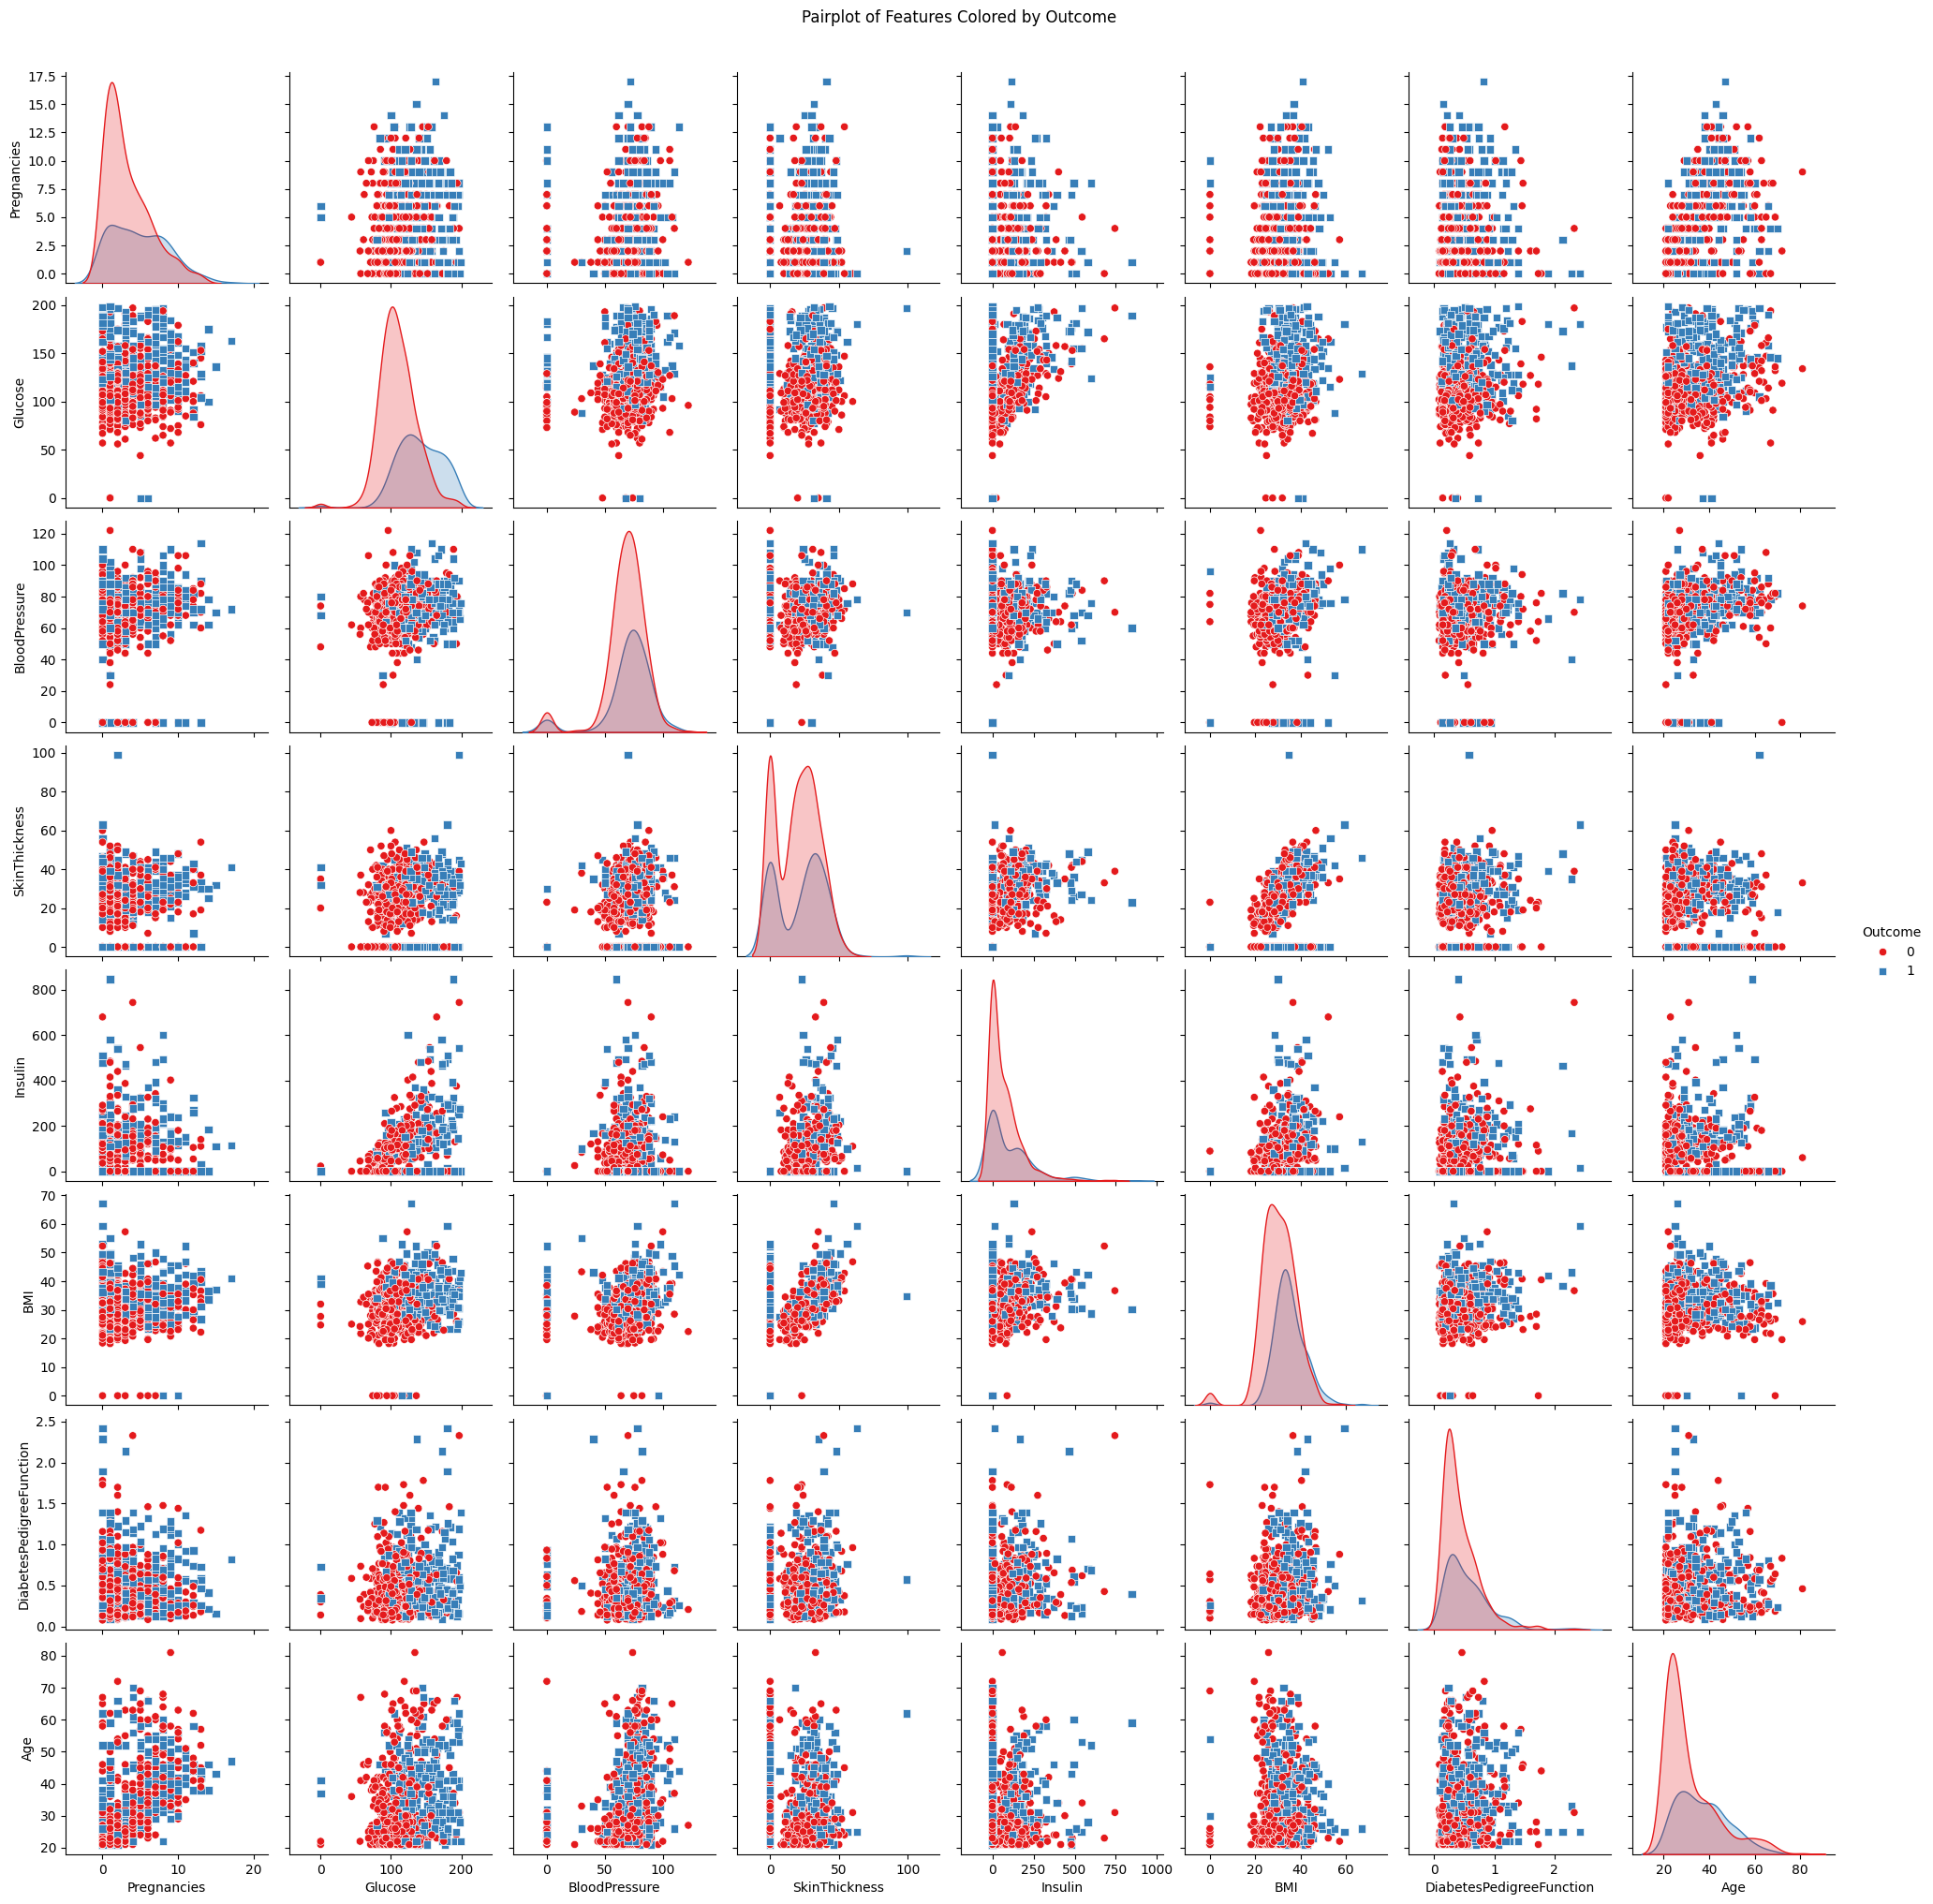

In [40]:
sns.pairplot(diabetes, hue='Outcome', palette='Set1', markers=["o", "s"])
plt.suptitle("Pairplot of Features Colored by Outcome", y=1.02)
plt.show()

In [12]:
rand_sampler = RandomOverSampler(sampling_strategy=1.0, random_state=42)

In [13]:
diabetes_x_resampled, diabetes_y_resampled = rand_sampler.fit_resample(diabetes_x_copy, diabetes_y_copy)

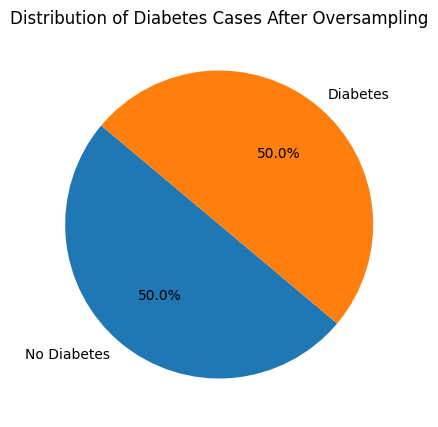

In [14]:
plt.figure(figsize=(9, 5))
plt.pie(diabetes_y_resampled.value_counts(), labels=["No Diabetes", "Diabetes"], autopct="%1.1f%%", startangle=140)
plt.title("Distribution of Diabetes Cases After Oversampling")
plt.show()

In [15]:
print("Balanced dataset:")
print(f"Positive cases:{diabetes_x_resampled[diabetes_y_resampled == 1].shape[0]}\n Negative cases:{diabetes_x_resampled[diabetes_y_resampled == 0].shape[0]}")

Balanced dataset:
Positive cases:500
 Negative cases:500


In [16]:
diabetes_x_resampled

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33
...,...,...,...,...,...,...,...,...
995,1,122,64,32,156,35.1,0.692,30
996,0,131,0,0,0,43.2,0.270,26
997,8,120,0,0,0,30.0,0.183,38
998,4,111,72,47,207,37.1,1.390,56


In [32]:
diabetes_combined=pd.concat([diabetes_x_resampled,diabetes_y_resampled],axis=1)

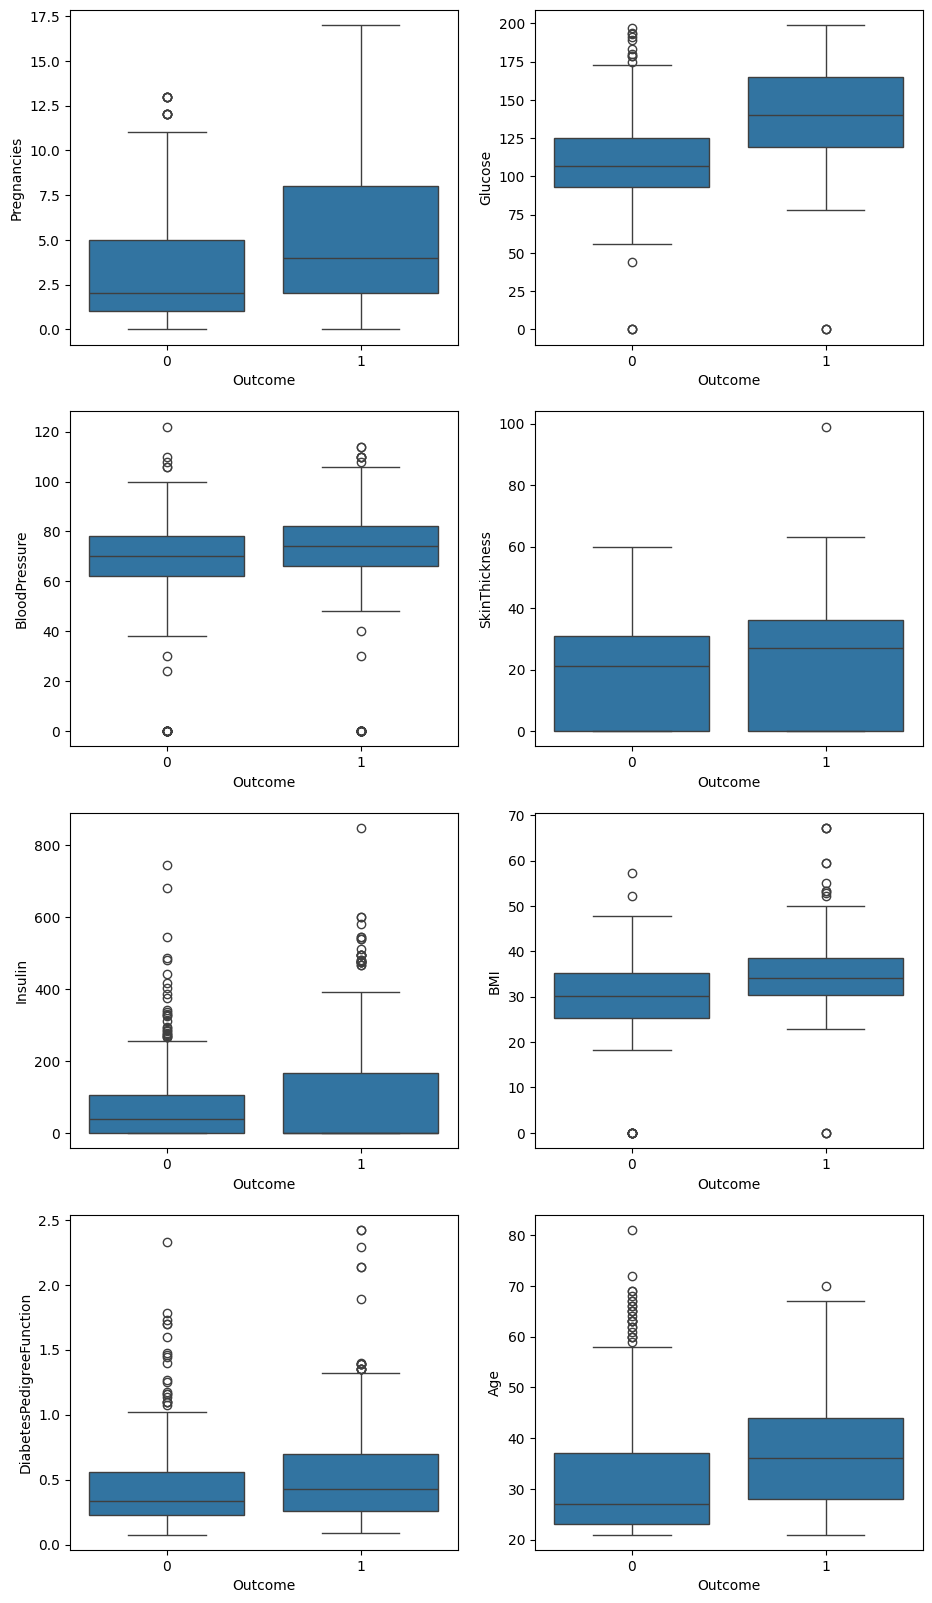

In [33]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(11, 20))
for i, col in enumerate(diabetes_combined.columns[:-1]):
    ax = axes[i // 2, i % 2]
    sns.boxplot(data=diabetes_combined, x="Outcome", y=col, ax=ax)

In [20]:
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[(df[col] < lower_bound)] = pd.NA
        df[(df[col] > upper_bound)] = pd.NA
    return df

In [21]:
diabetes_x_resampled = remove_outliers(diabetes_x_resampled, diabetes_x_resampled.columns)

In [22]:
diabetes_x_copy = remove_outliers(diabetes_x_copy, diabetes_x_copy.columns)

In [23]:
combined_df = pd.concat([diabetes_x_resampled, diabetes_y_resampled], axis=1)
combined_df_cp = pd.concat([diabetes_x_copy, diabetes_y_copy], axis=1)

In [24]:
combined_df.dropna(inplace=True)
combined_df_cp.dropna(inplace=True)

In [25]:
diabetes_x = combined_df.drop("Outcome", axis=1)
diabetes_y = combined_df["Outcome"]
diabetes_x_copy = combined_df_cp.drop("Outcome", axis=1)
diabetes_y_copy = combined_df_cp["Outcome"]

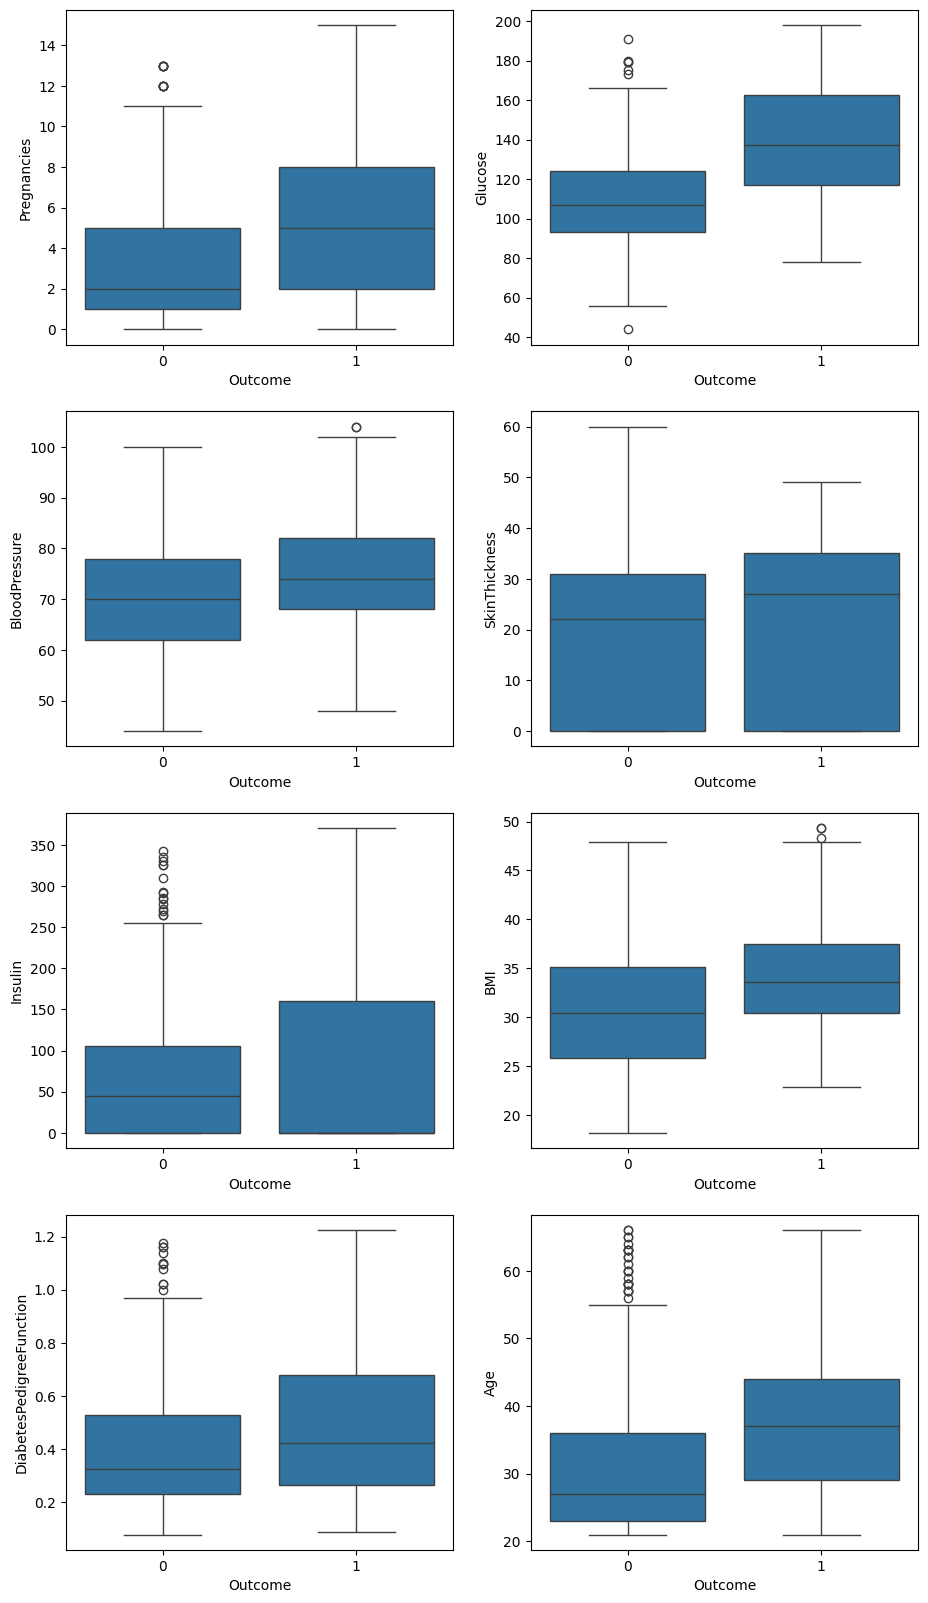

In [33]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(11, 20))
for i, col in enumerate(diabetes_x.columns):
    ax = axes[i // 2, i % 2]
    sns.boxplot(data=diabetes_x, x=diabetes_y, y=col, ax=ax)



In [34]:
print(f"After removing outliers, there are {diabetes_x.shape[0]} samples left.")
print(f"There are {diabetes_x[diabetes_y == 1].shape[0]} positive cases and {diabetes_x[diabetes_y== 0].shape[0]} negative cases")

After removing outliers, there are 835 samples left.
There are 394 positive cases and 441 negative cases


Correlation matrix of balanced dataset

<Axes: >

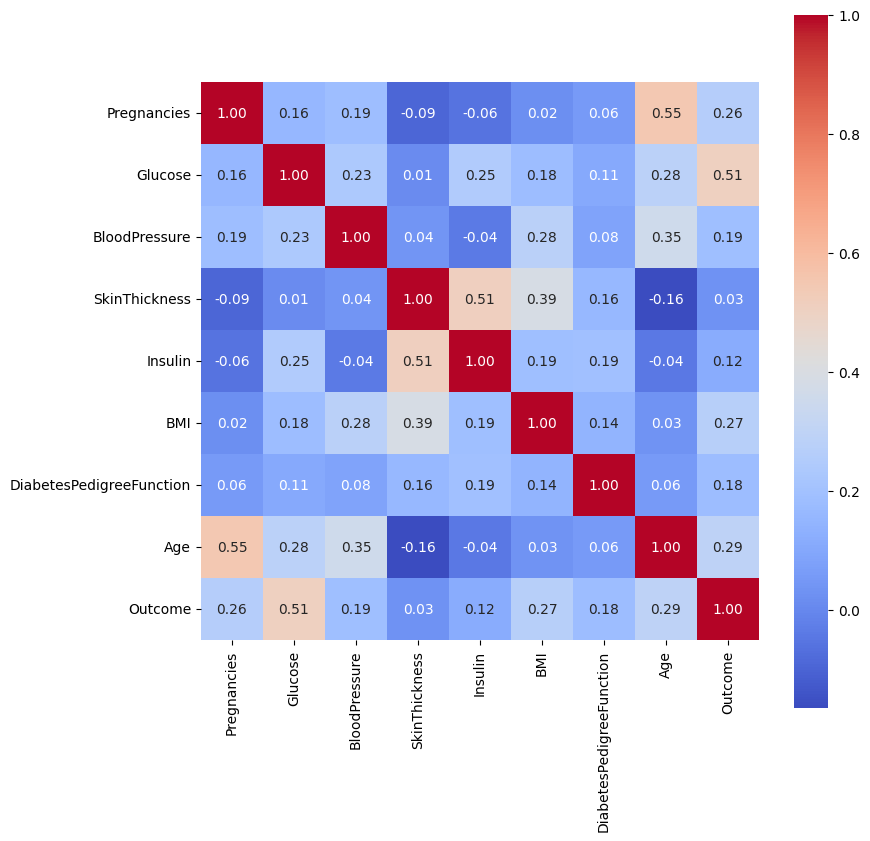

In [43]:
corr = combined_df.corr()
plt.figure(figsize=(9, 9))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)

Correlation matrix of unbalanced dataset

<Axes: >

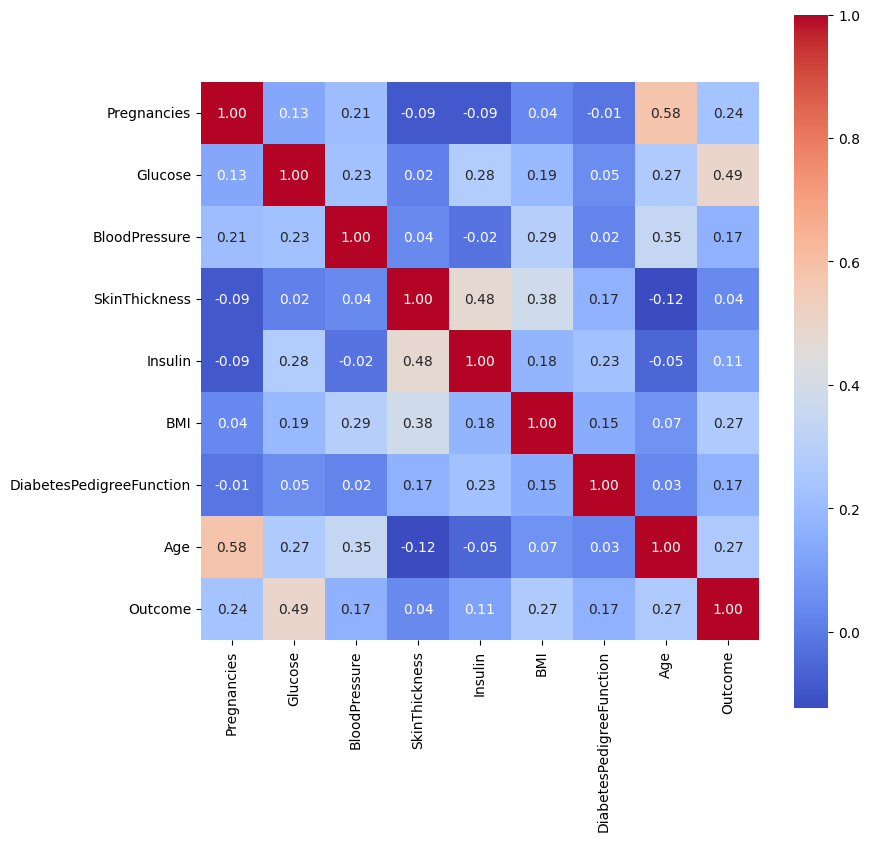

In [45]:
corr_cp = combined_df_cp.corr()
plt.figure(figsize=(9, 9))
sns.heatmap(corr_cp, annot=True, fmt=".2f", cmap="coolwarm", square=True)

In [46]:
scaler = StandardScaler()
diabetes_X_scaled = scaler.fit_transform(diabetes_x)
diabetes_X_scaled_cp = scaler.fit_transform(diabetes_x_copy)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(diabetes_X_scaled, diabetes_y, test_size=0.2, random_state=42)

In [48]:
X_train_02, X_test_02, y_train_02, y_test_02 = train_test_split(diabetes_X_scaled_cp, diabetes_y_copy, test_size=0.2, random_state=42)

Training a Random Forest Classifier on the balanced dataset

In [50]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [51]:
y_pred = rf_model.predict(X_test)

In [52]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8802395209580839


In [53]:
confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", confusion_mat)

Confusion Matrix:
 [[75 13]
 [ 7 72]]


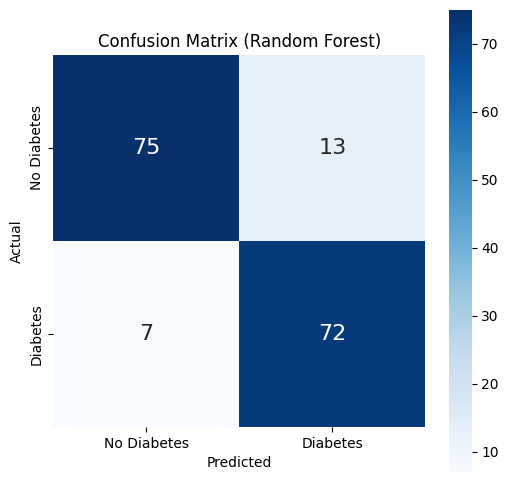

In [56]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mat, annot=True, annot_kws={"size": 16}, fmt='d', cmap='Blues', xticklabels=["No Diabetes", "Diabetes"], yticklabels=["No Diabetes", "Diabetes"], square=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Random Forest)")
plt.show()

In [57]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.85      0.88        88
           1       0.85      0.91      0.88        79

    accuracy                           0.88       167
   macro avg       0.88      0.88      0.88       167
weighted avg       0.88      0.88      0.88       167



Training a Random Forest Classifier on the unbalanced dataset

In [59]:
rf_model_02 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_02.fit(X_train_02, y_train_02)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [60]:
y_pred_02 = rf_model_02.predict(X_test_02)

In [61]:
accuracy_02 = accuracy_score(y_test_02, y_pred_02)
print("Accuracy on unbalanced dataset:", accuracy_02)

Accuracy on unbalanced dataset: 0.7421875


In [62]:
y_test_02

338    1
763    0
104    0
437    0
184    0
      ..
723    0
246    0
346    0
275    0
358    0
Name: Outcome, Length: 128, dtype: int64

In [63]:
confusion_matrix_02 = confusion_matrix(y_test_02, y_pred_02)
print("Confusion Matrix (Unbalanced Dataset):")
print(confusion_matrix_02)

Confusion Matrix (Unbalanced Dataset):
[[79 13]
 [20 16]]


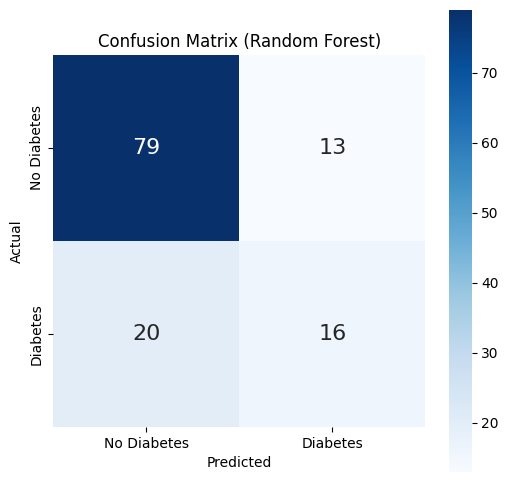

In [64]:
plt.figure(figsize=(6,6))
sns.heatmap(confusion_matrix_02, annot=True, annot_kws={"size": 16}, fmt='d', cmap='Blues', xticklabels=["No Diabetes", "Diabetes"], yticklabels=["No Diabetes", "Diabetes"], square=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Random Forest)")
plt.show()

In [65]:
print("Classification Report:\n", classification_report(y_test_02, y_pred_02))

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.86      0.83        92
           1       0.55      0.44      0.49        36

    accuracy                           0.74       128
   macro avg       0.67      0.65      0.66       128
weighted avg       0.73      0.74      0.73       128



Training a Multi-Layer Perceptron on the balanced dataset

In [142]:
class DiabetesModel(nn.Module):
    def __init__(self, input_size=8, hidden_size=14, output_size=1):
        super(DiabetesModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.out(x)
        return x

In [143]:
torch.manual_seed(42)
nn_model_01 = DiabetesModel()
nn_model_01
nn_model_01.to(device=device)

DiabetesModel(
  (fc1): Linear(in_features=8, out_features=14, bias=True)
  (fc2): Linear(in_features=14, out_features=14, bias=True)
  (out): Linear(in_features=14, out_features=1, bias=True)
)

In [144]:
torch.manual_seed(42)
nn_model_02 = DiabetesModel()
nn_model_02
nn_model_02.to(device=device)

DiabetesModel(
  (fc1): Linear(in_features=8, out_features=14, bias=True)
  (fc2): Linear(in_features=14, out_features=14, bias=True)
  (out): Linear(in_features=14, out_features=1, bias=True)
)

We are using cross entropy loss for calculating the loss of the model, and NADAM for optimizing the weights and biases of the model

In [145]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = NAdam(nn_model_01.parameters(), lr=0.01)

In [146]:
loss_fn2 = nn.BCEWithLogitsLoss()
optimizer2 = NAdam(nn_model_02.parameters(), lr=0.01)

In [147]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32, device=device).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32, device=device).view(-1, 1)

In [148]:
X_train_tensor1 = torch.tensor(X_train_02, dtype=torch.float32, device=device)
y_train_tensor1 = torch.tensor(y_train_02.values, dtype=torch.float32, device=device).view(-1, 1)
X_test_tensor1 = torch.tensor(X_test_02, dtype=torch.float32, device=device)
y_test_tensor1 = torch.tensor(y_test_02.values, dtype=torch.float32, device=device).view(-1, 1)

Training the neural network on the balanced dataset

In [149]:
epochs = 1000
best_model_loss = float('inf')
best_model_weights = None
patience = 7

loss_list = []
accuracy_list = []

for i in range(epochs):
    # train_loss = 0.0
    nn_model_01.train()

    outputs = nn_model_01(X_train_tensor)
    loss = loss_fn(outputs, y_train_tensor)
    loss_list.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    nn_model_01.eval()
    with torch.no_grad():
        outputs = nn_model_01(X_test_tensor)
        test_loss = loss_fn(outputs, y_test_tensor)
    y_pred = torch.sigmoid(outputs).round()
    accuracy = (y_pred == y_test_tensor).float().mean().item()
    accuracy_list.append(accuracy)

    if test_loss < best_model_loss:
        best_model_loss = test_loss
        best_model_weights = copy.deepcopy(nn_model_01.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {i+1}")
            break
    print(f"Epoch {i+1}/{epochs}, Train Loss: {loss.item():.4f}, Val Loss: {test_loss.item():.4f}")


Epoch 1/1000, Train Loss: 0.6923, Val Loss: 0.6869
Epoch 2/1000, Train Loss: 0.6869, Val Loss: 0.6823
Epoch 3/1000, Train Loss: 0.6820, Val Loss: 0.6764
Epoch 4/1000, Train Loss: 0.6764, Val Loss: 0.6688
Epoch 5/1000, Train Loss: 0.6694, Val Loss: 0.6588
Epoch 6/1000, Train Loss: 0.6604, Val Loss: 0.6463
Epoch 7/1000, Train Loss: 0.6490, Val Loss: 0.6315
Epoch 8/1000, Train Loss: 0.6355, Val Loss: 0.6143
Epoch 9/1000, Train Loss: 0.6199, Val Loss: 0.5949
Epoch 10/1000, Train Loss: 0.6030, Val Loss: 0.5750
Epoch 11/1000, Train Loss: 0.5853, Val Loss: 0.5558
Epoch 12/1000, Train Loss: 0.5682, Val Loss: 0.5389
Epoch 13/1000, Train Loss: 0.5522, Val Loss: 0.5242
Epoch 14/1000, Train Loss: 0.5377, Val Loss: 0.5100
Epoch 15/1000, Train Loss: 0.5244, Val Loss: 0.4983
Epoch 16/1000, Train Loss: 0.5125, Val Loss: 0.4879
Epoch 17/1000, Train Loss: 0.5018, Val Loss: 0.4791
Epoch 18/1000, Train Loss: 0.4919, Val Loss: 0.4711
Epoch 19/1000, Train Loss: 0.4831, Val Loss: 0.4650
Epoch 20/1000, Train 

In [150]:
nn_model_01.to(device="cpu")
nn_model_01.load_state_dict(best_model_weights)
nn_model_01.eval()

X_test_tensor = X_test_tensor.to(device="cpu")

with torch.no_grad():
    outputs = nn_model_01(X_test_tensor)
    y_pred = torch.sigmoid(outputs).round().numpy()

In [151]:
y_test_tensor = y_test_tensor.to(device="cpu")

print("Classification Report:")
print(classification_report(y_test_tensor, y_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.84      0.85        88
         1.0       0.83      0.85      0.84        79

    accuracy                           0.84       167
   macro avg       0.84      0.84      0.84       167
weighted avg       0.84      0.84      0.84       167



<Axes: >

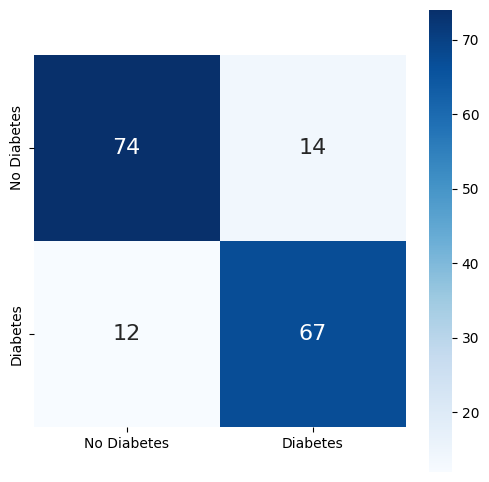

In [152]:
conf_matrix = confusion_matrix(y_test_tensor, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}, fmt='d', cmap='Blues', xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'], square=True)

In [153]:
print(f"Accuracy: {accuracy_score(y_test_tensor, y_pred):.4f}")

Accuracy: 0.8443


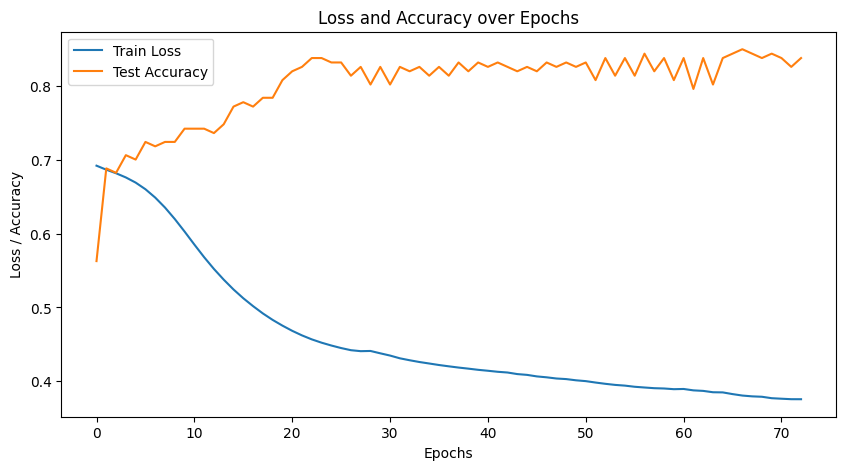

In [156]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(len(loss_list)), y=loss_list, label='Train Loss')
sns.lineplot(x=range(len(accuracy_list)), y=accuracy_list, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.title('Loss and Accuracy over Epochs')
plt.legend()
plt.show()

Training the neural network on the unbalanced dataset

In [157]:
epochs = 400
best_model_loss1 = float('inf')
best_model_weights1 = None
patience = 7

loss_list1 = []
accuracy_list1 = []

for i in range(epochs):
    # train_loss = 0.0
    nn_model_02.train()

    outputs1 = nn_model_02(X_train_tensor1)
    loss1 = loss_fn2(outputs1, y_train_tensor1)
    loss_list1.append(loss1.item())

    optimizer2.zero_grad()
    loss1.backward()
    optimizer2.step()

    nn_model_02.eval()
    with torch.no_grad():
        outputs1 = nn_model_02(X_test_tensor1)
        test_loss1 = loss_fn2(outputs1, y_test_tensor1)
    y_pred = torch.sigmoid(outputs1).round()
    accuracy = (y_pred == y_test_tensor1).float().mean().item()
    accuracy_list1.append(accuracy)

    if test_loss1 < best_model_loss1:
        best_model_loss1 = test_loss1
        best_model_weights1 = copy.deepcopy(nn_model_02.state_dict())
        patience_counter1 = 0
    else:
        patience_counter1 += 1
        if patience_counter1 >= patience:
            print(f"Early stopping at epoch {i+1}")
            break
    print(f"Epoch {i+1}/{epochs}, Train Loss: {loss1.item():.4f}, Val Loss: {test_loss1.item():.4f}")


Epoch 1/400, Train Loss: 0.6982, Val Loss: 0.6940
Epoch 2/400, Train Loss: 0.6881, Val Loss: 0.6849
Epoch 3/400, Train Loss: 0.6794, Val Loss: 0.6753
Epoch 4/400, Train Loss: 0.6702, Val Loss: 0.6646
Epoch 5/400, Train Loss: 0.6596, Val Loss: 0.6520
Epoch 6/400, Train Loss: 0.6469, Val Loss: 0.6371
Epoch 7/400, Train Loss: 0.6317, Val Loss: 0.6201
Epoch 8/400, Train Loss: 0.6138, Val Loss: 0.6022
Epoch 9/400, Train Loss: 0.5938, Val Loss: 0.5833
Epoch 10/400, Train Loss: 0.5725, Val Loss: 0.5659
Epoch 11/400, Train Loss: 0.5512, Val Loss: 0.5519
Epoch 12/400, Train Loss: 0.5309, Val Loss: 0.5404
Epoch 13/400, Train Loss: 0.5126, Val Loss: 0.5316
Epoch 14/400, Train Loss: 0.4969, Val Loss: 0.5252
Epoch 15/400, Train Loss: 0.4829, Val Loss: 0.5201
Epoch 16/400, Train Loss: 0.4703, Val Loss: 0.5167
Epoch 17/400, Train Loss: 0.4592, Val Loss: 0.5143
Epoch 18/400, Train Loss: 0.4492, Val Loss: 0.5122
Epoch 19/400, Train Loss: 0.4401, Val Loss: 0.5112
Epoch 20/400, Train Loss: 0.4317, Val Lo

In [158]:
nn_model_02.load_state_dict(best_model_weights1)
nn_model_02.to(device="cpu")
X_test_tensor1 = X_test_tensor1.to(device="cpu")

nn_model_02.eval()
with torch.no_grad():
    outputs1 = nn_model_02(X_test_tensor1)
    y_pred_02 = torch.sigmoid(outputs1).round().numpy()

In [159]:
y_test_tensor1 = y_test_tensor1.to(device="cpu")

print("Classification Report:")
print(classification_report(y_test_tensor1, y_pred_02))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.88      0.84        92
         1.0       0.59      0.44      0.51        36

    accuracy                           0.76       128
   macro avg       0.70      0.66      0.67       128
weighted avg       0.74      0.76      0.75       128



In [160]:
print(f"Accuracy: {accuracy_score(y_test_tensor1, y_pred_02):.4f}")

Accuracy: 0.7578


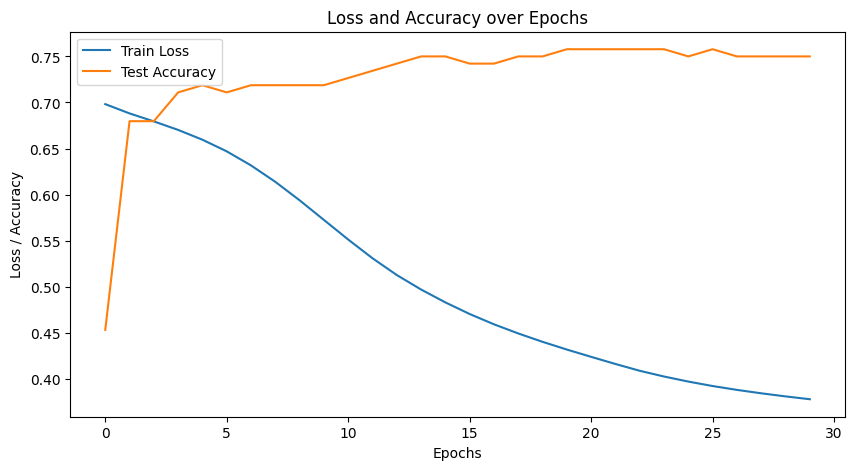

In [161]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(len(loss_list1)), y=loss_list1, label='Train Loss')
sns.lineplot(x=range(len(accuracy_list1)), y=accuracy_list1, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.title('Loss and Accuracy over Epochs')
plt.legend()
plt.show()

Training a Support Vector Machine on the balanced dataset

In [162]:
svc_model = SVC(random_state=42, kernel='rbf')

In [163]:
svc_model.fit(X_train, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [164]:
y_pred = svc_model.predict(X_test)

In [165]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8084


In [166]:
confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", confusion_mat)

Confusion Matrix:
 [[73 15]
 [17 62]]


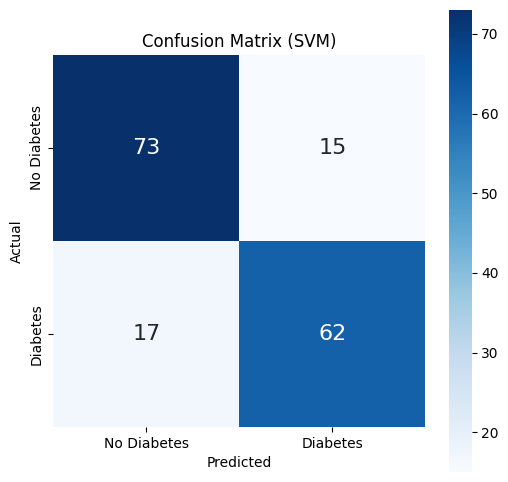

In [167]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mat, annot=True, annot_kws={"size": 16}, fmt='d', cmap='Blues', xticklabels=["No Diabetes", "Diabetes"], yticklabels=["No Diabetes", "Diabetes"], square=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (SVM)")
plt.show()

In [168]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.83      0.82        88
           1       0.81      0.78      0.79        79

    accuracy                           0.81       167
   macro avg       0.81      0.81      0.81       167
weighted avg       0.81      0.81      0.81       167



Training a Support Vector Machine on the unbalanced dataset.

In [169]:
svc_model_02 = SVC(random_state=42, kernel='rbf')

In [170]:
svc_model_02.fit(X_train_02, y_train_02)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [171]:
y_pred_02 = svc_model_02.predict(X_test_02)

In [172]:
accuracy_02 = accuracy_score(y_test_02, y_pred_02)
print(f"Accuracy: {accuracy_02:.4f}")

Accuracy: 0.7578


In [173]:
confusion_mat = confusion_matrix(y_test_02, y_pred_02)
print("Confusion Matrix:\n", confusion_mat)

Confusion Matrix:
 [[81 11]
 [20 16]]


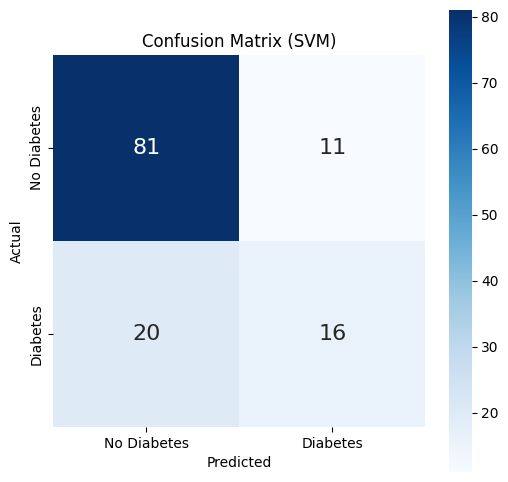

In [174]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mat, annot=True, annot_kws={"size": 16}, fmt='d', cmap='Blues', xticklabels=["No Diabetes", "Diabetes"], yticklabels=["No Diabetes", "Diabetes"], square=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (SVM)")
plt.show()

In [175]:
print("Classification Report:\n", classification_report(y_test_02, y_pred_02))

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.88      0.84        92
           1       0.59      0.44      0.51        36

    accuracy                           0.76       128
   macro avg       0.70      0.66      0.67       128
weighted avg       0.74      0.76      0.75       128



Plotting the ROC-AUC curves of the models trained on the balanced dataset

In [176]:
y_pred_rf = rf_model.predict_proba(X_test)[:, 1]
y_pred_svc = svc_model.decision_function(X_test)
y_pred_nn = torch.sigmoid(nn_model_01(X_test_tensor)).detach().numpy()

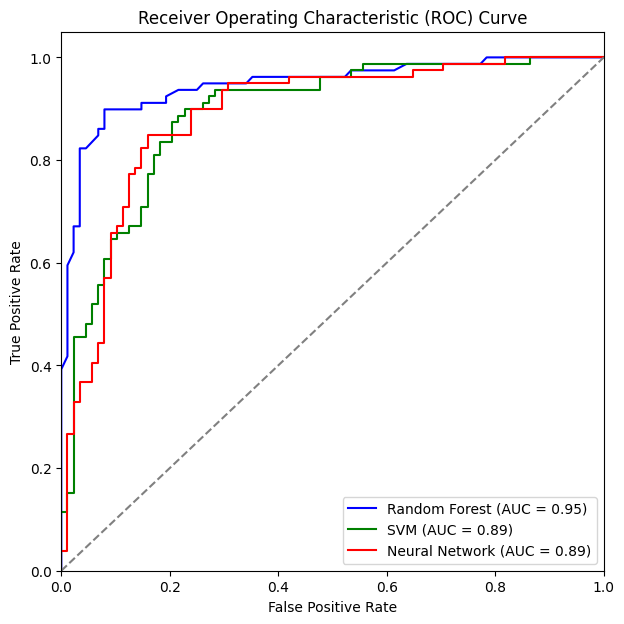

In [179]:
plt.figure(figsize=(7, 7))

fpr1, tpr1, _ = roc_curve(y_test, y_pred_rf)
fpr2, tpr2, _ = roc_curve(y_test, y_pred_svc)
fpr3, tpr3, _ = roc_curve(y_test, y_pred_nn)

roc_auc_rf = auc(fpr1, tpr1)
roc_auc_svc = auc(fpr2, tpr2)
roc_auc_nn = auc(fpr3, tpr3)

plt.plot(fpr1, tpr1, color='blue', label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr2, tpr2, color='green', label=f'SVM (AUC = {roc_auc_svc:.2f})')
plt.plot(fpr3, tpr3, color='red', label=f'Neural Network (AUC = {roc_auc_nn:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [180]:
nn_model_01.eval()
with torch.no_grad():
    outputs = nn_model_01(X_test_tensor)
    y_pred = torch.sigmoid(outputs).round().numpy()

results_df = pd.DataFrame({
    'Model': ['Random Forest', 'Neural Network', 'SVM'],
    'Accuracy': [
        accuracy_score(y_test, rf_model.predict(X_test)),
        accuracy_score(y_test, y_pred),
        accuracy_score(y_test, svc_model.predict(X_test)),
    ],
    'AUC': [roc_auc_rf, roc_auc_svc, roc_auc_nn],
    'F1-Score': [
        f1_score(y_test, rf_model.predict(X_test)),
        f1_score(y_test, y_pred),
        f1_score(y_test, svc_model.predict(X_test)),
    ],
    'Precision': [
        precision_score(y_test, rf_model.predict(X_test)),
        precision_score(y_test, y_pred),
        precision_score(y_test, svc_model.predict(X_test)),
    ],
    'Recall': [
        recall_score(y_test, rf_model.predict(X_test)),
        recall_score(y_test, y_pred),
        recall_score(y_test, svc_model.predict(X_test)),
    ]
})

In [181]:
results_df

,Model,Accuracy,AUC,F1-Score,Precision,Recall
0,Random Forest,0.880240,0.946778,0.878049,0.847059,0.911392
1,Neural Network,0.844311,0.889097,0.837500,0.827160,0.848101
2,SVM,0.808383,0.886939,0.794872,0.805195,0.784810
